In [1]:
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [2]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    pad_token_id=tokenizer.eos_token_id,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [3]:
messages = [
    {"role": "system", "content": 
     '''You are a stock sentiment analyzer. Your task is to evaluate news headlines for their potential impact on a specific stock.
     
Input Format:
    User input is in the following format:
        Stock: (Name of the company) 
        Symbol: (The stock symbol also called ticker symbol) 
        Headline: (News headline that you have to analyze for sentiment of the given stock)

Analysis Guidelines:
    Evaluate how the news headline might affect the price of only the stock specified by the user in the input and generate a sentiment score between -1 and 1.
    A score close to -1 indicates a strong negative impact, suggesting the news could significantly drive the stock price down.
    A score near 0 represents a neutral impact, implying little to no effect on the stock price.
    Conversely, a score close to 1 reflects a strong positive impact, likely driving the stock price up.
    When generating the score, consider whether the news is surprising i.e., if it contains new information - or already priced in.
    Explain in detail the rationale behind the score, highlighting why the news is positive, negative, or neutral for the given stock's price.

Output Format:
    Return the result as JSON in the following format:
        {"sentiment_score": (The sentiment score - float between -1 and 1), "sentiment_label": (One of "Strongly Negative", "Mildly Negative", "Neutral", "Mildly Positive", "Strongly Positive", depending on ), "rationale": (Your explanation for the score)}
    Provide the JSON output only. Do not include any other text.'''},
    {"role": "user", "content": "Stock: Tesla Inc \n Symbol: TSLA \n Headline: Protests erupt at Tesla dealers as China holds FSD hostage in tariff war"},
]
outputs = pipe(
    messages,
    max_new_tokens=512,
    temperature=0.1, return_full_text=False,
)

print(outputs[0]["generated_text"])


{"sentiment_score": -0.45, "sentiment_label": "Mildly Negative", "rationale": "The headline suggests that Tesla is facing challenges in China, which is a significant market for the company. The mention of protests at Tesla dealers and China holding Full Self-Driving (FSD) technology hostage in a tariff war indicates that Tesla's operations and products are being impacted by the situation. This news is likely to have a mildly negative impact on the stock price, as it may affect Tesla's sales and revenue in China. However, the sentiment score is not strongly negative as the company has a strong brand and a diverse product portfolio, which may help mitigate the impact of this news. Additionally, the fact that the headline does not mention any significant financial losses or major setbacks for Tesla suggests that the impact may be limited."}


In [4]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import feedparser
from urllib.parse import quote
import pickle
from datetime import datetime

In [5]:
stock_symbol = 'TSLA'
stock_name = 'Tesla Inc'
stock_query = '"TSLA" OR "NASDAQ:TSLA" OR "Tesla Inc"'
start_date = '2021-01-01'
end_date = '2025-01-01'

In [6]:
def get_stock_data(symbol, start, end):
    stock = yf.Ticker(symbol)
    df = stock.history(start=start, end=end)
    df["Change"] = df['Close'].pct_change()
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    return df

In [7]:
stock_df = get_stock_data(stock_symbol, start_date, end_date)

In [8]:
stock_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,date
Date,,,,,,,,,
2021-01-04 00:00:00-05:00,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0,NaN,2021-01-04
2021-01-05 00:00:00-05:00,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0,0.007317,2021-01-05
2021-01-06 00:00:00-05:00,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0,0.028390,2021-01-06
2021-01-07 00:00:00-05:00,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0,0.079447,2021-01-07
2021-01-08 00:00:00-05:00,285.333344,294.829987,279.463318,293.339996,225166500,0.0,0.0,0.078403,2021-01-08
...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,435.899994,462.779999,435.140015,462.279999,59551800,0.0,0.0,0.073572,2024-12-24
2024-12-26 00:00:00-05:00,465.160004,465.329987,451.019989,454.130005,76366400,0.0,0.0,-0.017630,2024-12-26
2024-12-27 00:00:00-05:00,449.519989,450.000000,426.500000,431.660004,82666800,0.0,0.0,-0.049479,2024-12-27


In [9]:
with open('TSLA_stock.pkl', 'wb') as f:
    pickle.dump(stock_df, f)

In [9]:
with open('TSLA_stock.pkl', 'rb') as f:
    stock_df = pickle.load(f)

In [10]:
def get_news(query, dates):
    all_articles = {}
    for start, end in zip(dates[:-1], dates[1:]):
        feed = feedparser.parse(f'https://news.google.com/rss/search?q={quote(query)}+before:{end}+after:{start}')
        for entry in feed.entries:
            if entry:
                all_articles[entry.title] = entry.published
        time.sleep(2)
    print(f"Total Articles Collected: {len(all_articles)}")
    return all_articles

In [11]:
dates = stock_df.date.to_list()
dates = [str(x.date()) for x in dates]

In [ ]:
all_articles = get_news(stock_query, dates)

In [13]:
with open('TSLA_news.pkl', 'wb') as f:
    pickle.dump(all_articles, f)

In [12]:
with open('TSLA_news.pkl', 'rb') as f:
    all_articles = pickle.load(f)

In [15]:
print("Mean number of news headlines per trading day = ", len(all_articles)/len(stock_df))

Mean number of news headlines per trading day =  7.42089552238806


In [16]:
i = 0
for title, published_time in all_articles.items():
    print(title, ' | ', published_time)
    i += 1
    if i==10:
        break

Tesla (TSLA) Breaks Out After Beating Delivery Targets - Investopedia  |  Mon, 04 Jan 2021 08:00:00 GMT
Elon Musk nears Jeff Bezos’ net worth; Tesla sets course for Facebook’s valuation - TESLARATI  |  Tue, 05 Jan 2021 08:00:00 GMT
Tesla (TSLA) announces a new battery cell deal with Panasonic - Electrek  |  Mon, 04 Jan 2021 08:00:00 GMT
Up 8x, What Really Changed For Tesla Stock In 2020? - Forbes  |  Tue, 05 Jan 2021 08:00:00 GMT
Nio (NIO) ends 2020 on a high note with triple-digit growth in deliveries - AlphaStreet  |  Mon, 04 Jan 2021 08:00:00 GMT
Morgan Stanley raises Tesla (TSLA) price target to $810, bull case of $1,232 per share - TESLARATI  |  Tue, 05 Jan 2021 08:00:00 GMT
Tesla, China, And Europe - A Tale Of Market Share (NASDAQ:TSLA) - Seeking Alpha  |  Tue, 05 Jan 2021 08:00:00 GMT
Apple (AAPL) Supplier Accused of Using Forced Labor in China - Investopedia  |  Tue, 05 Jan 2021 08:00:00 GMT
Tesla’s $12B capital raise in 2020 fully funds Giga Texas buildout - TESLARATI  |  Tue,

In [17]:
def analyze_sentiment(news, symbol, name):
    sentiments = []
    dates = []
    titles = []
    for title, date in news.items():
        try:
            date_obj = datetime.strptime(date, '%a, %d %b %Y %H:%M:%S %Z')
            if date_obj.hour<21:   # Only keep news published before US market close 21:00 GMT 
                dates.append(date_obj.strftime('%Y-%m-%d'))
                titles.append(title)
        except:
            continue

    model_id = "meta-llama/Llama-3.2-3B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    pipe = pipeline(
        "text-generation",
        model=model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        batch_size=32,
        tokenizer=tokenizer,
        num_workers=8
    )
  
    messages = [[
    {"role": "system", "content": 
     '''You are a stock sentiment analyzer. Your task is to evaluate news headlines for their potential impact on a specific stock.
     
Input Format:
    User input is in the following format:
        Stock: (Name of the company) 
        Symbol: (The stock symbol also called ticker symbol) 
        Headline: (News headline that you have to analyze for sentiment of the given stock)

Analysis Guidelines:
    Evaluate how the news headline might affect the price of only the stock specified by the user in the input and generate a sentiment score between -1 and 1.
    A score close to -1 indicates a strong negative impact, suggesting the news could significantly drive the stock price down.
    A score near 0 represents a neutral impact, implying little to no effect on the stock price.
    Conversely, a score close to 1 reflects a strong positive impact, likely driving the stock price up.
    When generating the score, consider whether the news is surprising i.e., if it contains new information - or already priced in.
    Explain in detail the rationale behind the score, highlighting why the news is positive, negative, or neutral for the given stock's price.

Output Format:
    Return the result as JSON in the following format:
        {"sentiment_score": (The sentiment score - float between -1 and 1), "sentiment_label": (One of "Strongly Negative", "Mildly Negative", "Neutral", "Mildly Positive", "Strongly Positive", depending on ), "rationale": (Your explanation for the score)}
    Provide the JSON output only. Do not include any other text.'''},
    {"role": "user", "content": f"Stock: {name} \n Symbol: {symbol} \n Headline: {title}"}] for title in titles]

    outputs = pipe(
        messages,
        max_new_tokens=9,
        temperature=0.05, 
        return_full_text=False,
    )
    for output in outputs:
        try:
            out = output[0]["generated_text"].split(',')[0]
            
        except:
            out = output[0]["generated_text"]
        sentiments.append(float(out.split(' ')[-1]))
    return pd.DataFrame({'date':dates, 'title':titles, 'sentiment':sentiments})

In [17]:
sentiments = analyze_sentiment(all_articles, stock_symbol, stock_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [18]:
with open('TSLA_news_sentiment.pkl', 'wb') as f:
    pickle.dump(sentiments, f)

In [18]:
with open('TSLA_news_sentiment.pkl', 'rb') as f:
    sentiments = pickle.load(f)

In [19]:
sentiments

,date,title,sentiment
0,2021-01-04,Tesla (TSLA) Breaks Out After Beating Delivery...,0.73
1,2021-01-05,Elon Musk nears Jeff Bezos’ net worth; Tesla s...,0.55
2,2021-01-04,Tesla (TSLA) announces a new battery cell deal...,0.55
3,2021-01-05,"Up 8x, What Really Changed For Tesla Stock In ...",0.80
4,2021-01-04,Nio (NIO) ends 2020 on a high note with triple...,-0.43
...,...,...,...
7427,2024-12-31,TSLA/MicroStrategy How Stories Can Drive Stock...,0.20
7428,2024-12-31,Is Tesla Stock a Buy in 2025? - The Globe and ...,0.20
7429,2024-12-31,Is Tesla’s Stock a Future Proof Investment? A ...,0.73
7430,2024-12-31,Prediction: Tesla Stock Could Stall Out on Jan...,-0.50


In [20]:
news_df = sentiments.drop('title', axis=1)
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df.groupby("date")["sentiment"].sum().reset_index()   # sum sentiments of all news headlines in a day
merged = pd.merge(news_df, stock_df, on="date", how="inner")

if merged['date'].is_monotonic_increasing:
    print("The DataFrame is sorted in ascending order by the 'date' column.")
elif merged['date'].is_monotonic_decreasing:
    print("The DataFrame is sorted in descending order by the 'date' column.")
else:
    print("The DataFrame is NOT sorted by the 'date' column.")

The DataFrame is sorted in ascending order by the 'date' column.


In [21]:
merged

,date,sentiment,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
0,2021-01-04,0.85,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0,NaN
1,2021-01-05,2.08,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0,0.007317
2,2021-01-06,0.53,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0,0.028390
3,2021-01-07,3.90,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0,0.079447
4,2021-01-08,2.88,285.333344,294.829987,279.463318,293.339996,225166500,0.0,0.0,0.078403
...,...,...,...,...,...,...,...,...,...,...
997,2024-12-24,5.01,435.899994,462.779999,435.140015,462.279999,59551800,0.0,0.0,0.073572
998,2024-12-26,8.62,465.160004,465.329987,451.019989,454.130005,76366400,0.0,0.0,-0.017630
999,2024-12-27,0.16,449.519989,450.000000,426.500000,431.660004,82666800,0.0,0.0,-0.049479
1000,2024-12-30,-0.50,419.399994,427.000000,415.750000,417.410004,64941000,0.0,0.0,-0.033012


In [22]:
thr = np.abs(merged.sentiment).quantile(q=0.3)
print(thr)

# Define signals - buy(sentiment > 0.2 and Change >0), sell(sentiment < -0.2 and Change <0)
merged["signal"] = 0
merged.loc[(merged["sentiment"] > thr) & (merged["Change"] > 0), "signal"] = 1  # Buy
merged.loc[(merged["sentiment"] < -thr) & (merged["Change"] < 0), "signal"] = -1  # Sell

0.38


In [23]:
merged

,date,sentiment,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,signal
0,2021-01-04,0.85,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0,NaN,0
1,2021-01-05,2.08,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0,0.007317,1
2,2021-01-06,0.53,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0,0.028390,1
3,2021-01-07,3.90,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0,0.079447,1
4,2021-01-08,2.88,285.333344,294.829987,279.463318,293.339996,225166500,0.0,0.0,0.078403,1
...,...,...,...,...,...,...,...,...,...,...,...
997,2024-12-24,5.01,435.899994,462.779999,435.140015,462.279999,59551800,0.0,0.0,0.073572,1
998,2024-12-26,8.62,465.160004,465.329987,451.019989,454.130005,76366400,0.0,0.0,-0.017630,0
999,2024-12-27,0.16,449.519989,450.000000,426.500000,431.660004,82666800,0.0,0.0,-0.049479,0
1000,2024-12-30,-0.50,419.399994,427.000000,415.750000,417.410004,64941000,0.0,0.0,-0.033012,-1


In [24]:
merged["returns"] = merged["Change"] * merged["signal"].shift(1)
merged

,date,sentiment,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,signal,returns
0,2021-01-04,0.85,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0,NaN,0,NaN
1,2021-01-05,2.08,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0,0.007317,1,0.000000
2,2021-01-06,0.53,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0,0.028390,1,0.028390
3,2021-01-07,3.90,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0,0.079447,1,0.079447
4,2021-01-08,2.88,285.333344,294.829987,279.463318,293.339996,225166500,0.0,0.0,0.078403,1,0.078403
...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024-12-24,5.01,435.899994,462.779999,435.140015,462.279999,59551800,0.0,0.0,0.073572,1,0.000000
998,2024-12-26,8.62,465.160004,465.329987,451.019989,454.130005,76366400,0.0,0.0,-0.017630,0,-0.017630
999,2024-12-27,0.16,449.519989,450.000000,426.500000,431.660004,82666800,0.0,0.0,-0.049479,0,-0.000000
1000,2024-12-30,-0.50,419.399994,427.000000,415.750000,417.410004,64941000,0.0,0.0,-0.033012,-1,-0.000000


Sharpe Ratio Strategy: 0.75
Sharpe Ratio BuyHold: 0.49
Strategy Max Drawdown: -47.16%
Buy & Hold Max Drawdown: -73.63%
Win Ratio: 50.12%


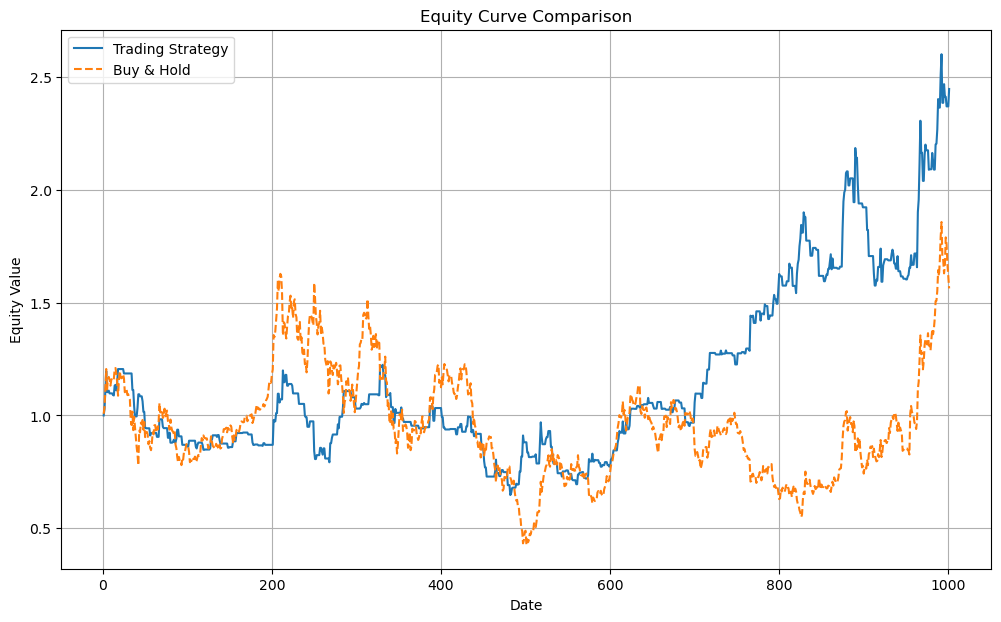

In [26]:
# Cumulative Returns (Equity Curve)
merged['Strategy Equity'] = (1 + merged['returns']).cumprod()
merged['BuyHold Equity'] = (1 + merged['Change']).cumprod()

# Sharpe Ratio (Assuming risk-free rate = 0)
sharpe_ratio_strategy = merged['returns'].mean() / merged['returns'].std() * np.sqrt(252)
sharpe_ratio_buyhold = merged['Change'].mean() / merged['Change'].std() * np.sqrt(252)

# Win Ratio
win_ratio = ( (merged['returns']>0).sum() / (merged['signal']!=0).sum() ).item()

# Maximum Drawdown
def max_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return drawdown.min()

strategy_max_drawdown = max_drawdown(merged['Strategy Equity'])
buyhold_max_drawdown = max_drawdown(merged['BuyHold Equity'])

# Display Results
print(f"Sharpe Ratio Strategy: {sharpe_ratio_strategy:.2f}")
print(f"Sharpe Ratio BuyHold: {sharpe_ratio_buyhold:.2f}")
print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
print(f"Buy & Hold Max Drawdown: {buyhold_max_drawdown:.2%}")
print(f"Win Ratio: {win_ratio:.2%}")

# Plot Equity Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(merged['Strategy Equity'], label='Trading Strategy')
plt.plot(merged['BuyHold Equity'], label='Buy & Hold', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Equity Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()
